# Hamiltonian NN (HNN) in (q, p) evaluation
by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
solver = scipy.integrate.solve_ivp

In [ ]:
import torch.nn as nn
device = 'cpu'


In [ ]:
N = 2
O = np.zeros((N,N))
Id = np.eye(N)
S = np.vstack([np.hstack([O,Id]),np.hstack([-Id,O])])
St = torch.tensor(-S, dtype=torch.float32).to(device)
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return torch.matmul(gradient[0],St)

  def fvec(self,t,x):
    return self.grad(x)

In [ ]:
input_size = 4
output_size = 1
hidden_size = 200
num_trials = 10
mynet = MLP(input_size,hidden_size,output_size).to('cpu')


In [ ]:
M = 100 * 1
tend = 5.0 * 1
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

In [ ]:
def mass_matrix(q1, q2, m1, m2, l1, l2):
    """ 
    M(q) matrix is computed
    q1, q2: scalar or numpy array.
    return shape: (..., 2, 2) if q1, q2 are arrays, (2, 2) if input q1, q2 are scalars.
    """
    cos12 = np.cos(q1 - q2)
    
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2

    # Initialize M_q upon input shape
    if np.ndim(q1) > 0:
        # q1: array --> (..., 2, 2)
        M_q = np.zeros(q1.shape + (2, 2))
    else:
        # q1: scalar --> (2, 2)
        M_q = np.zeros((2, 2))
    
    # Value assignment by broadcasting
    M_q[..., 0, 0] = M11
    M_q[..., 0, 1] = M12
    M_q[..., 1, 0] = M12 # M21 (symmetric)
    M_q[..., 1, 1] = M22
    
    return M_q

def mass_matrix_scalar(q1, q2, m1, m2, l1, l2):
    """ 
    M(q) matrix is computed.
    return shape: (2, 2)
    """
    cos12 = np.cos(q1 - q2)
    
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2
    
    return np.array([[M11, M12], [M12, M22]]) # (2, 2) 반환

def mass_matrix_dot_scalar(q1, q2, v1, v2, m1, m2, l1, l2):
    """
    Computes M_dot(q, v), the time derivative of mass-matrix M(q).
    v1, v2: time derivative of q1, q2 (Angular Velocity)
    return shape: (2, 2)
    """
    sin12 = np.sin(q1 - q2)
    
    delta_v = v1 - v2

    M_dot11 = 0.0 # M11 is a constant
    M_dot12 = -m2 * l1 * l2 * sin12 * delta_v
    M_dot22 = 0.0 # M22 is a constant

    return np.array([[M_dot11, M_dot12], [M_dot12, M_dot22]]) # (2, 2)

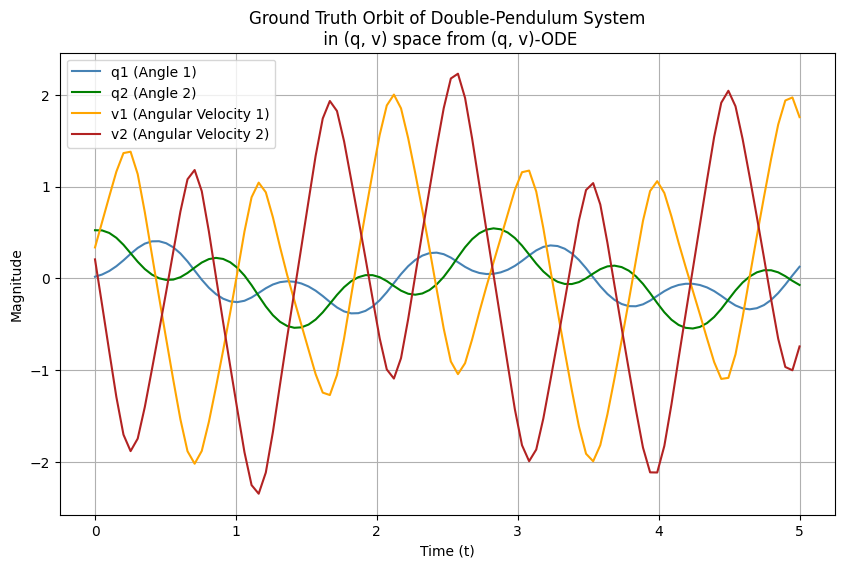

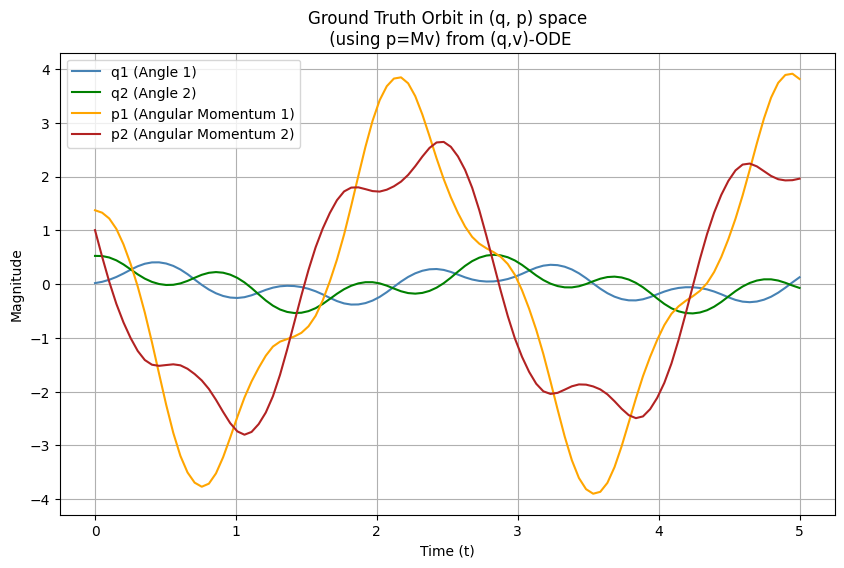

HNN x0 (q, p): [0.01825532 0.52412613 1.37291386 1.00350838]


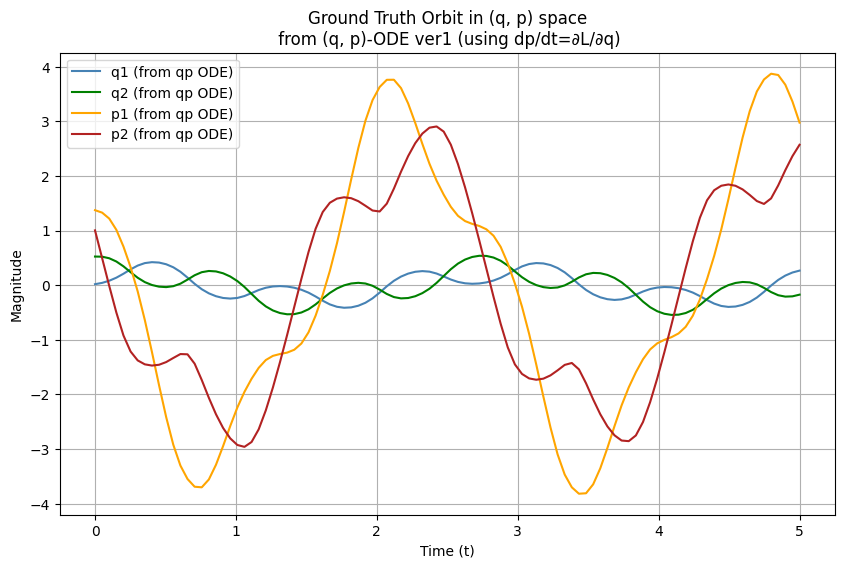

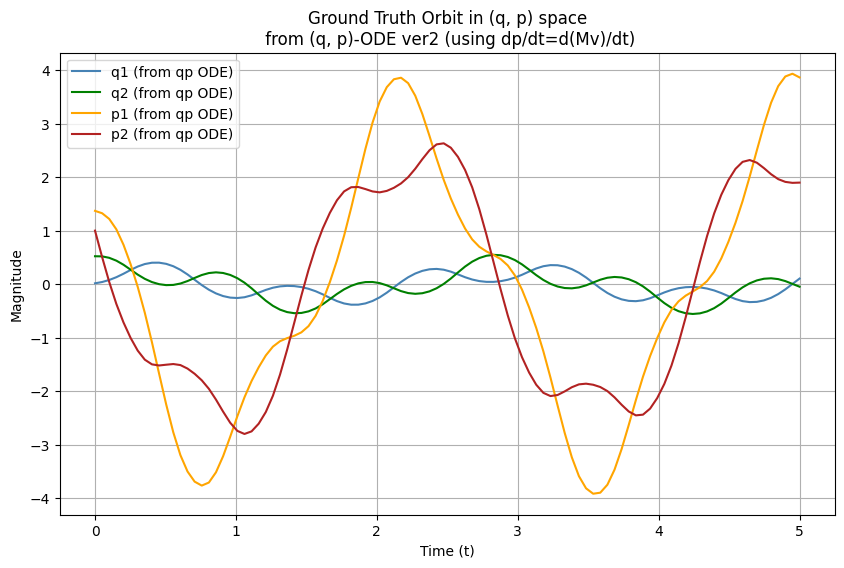

In [ ]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

# equations of motion (q, v space)
def func_qv(t, state):
  """
  ODE of the double-pendulum system (q, v space)
  state = [q1, q2, v1, v2]
  dvdt = [v1, v2, a1, a2]
  """
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  
  # dq/dt = v
  dvdt[0] = state[2] # v1
  dvdt[1] = state[3] # v2
  
  # dv/dt = a (acceleration)
  # a1
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  # a2
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  
  return dvdt

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)

sol = solver(func_qv, [0, tend], state[0], t_eval=t_eval)
tval = sol['t']
q1 = sol['y'][0]
q2 = sol['y'][1]
v1 = sol['y'][2]
v2 = sol['y'][3]

# (q, v) orbit or trajectory
true_x_qv = sol['y'].T
  
plt.figure(figsize=(10, 6))
plt.plot(tval, q1, 'steelblue', label='q1 (Angle 1)')
plt.plot(tval, q2, 'g', label='q2 (Angle 2)')
plt.plot(tval, v1, 'orange', label='v1 (Angular Velocity 1)')
plt.plot(tval, v2, 'firebrick', label='v2 (Angular Velocity 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('Ground Truth Orbit of Double-Pendulum System\n in (q, v) space from (q, v)-ODE')
plt.legend()
plt.grid(True)
plt.show()

# For HNN, converted to (q, p) orbit: p = M v, M=mass matrix
def compute_momentum(q1, q2, v1, v2, m1, m2, l1, l2):
    cos_q1q2 = np.cos(q1 - q2)
    p1 = (m1 + m2) * l1**2 * v1 + m2 * l1 * l2 * v2 * cos_q1q2
    p2 = m2 * l2**2 * v2 + m2 * l1 * l2 * v1 * cos_q1q2
    return p1, p2
# -----------------------------------------------------------
p1, p2 = compute_momentum(q1, q2, v1, v2, m1, m2, l1, l2)

true_x_qv2qp = np.vstack([q1, q2, p1, p2]).T  # (M, 4) [q1, q2, p1, p2]

plt.figure(figsize=(10, 6))
plt.plot(tval, true_x_qv2qp[:,0], 'steelblue', label='q1 (Angle 1)')
plt.plot(tval, true_x_qv2qp[:,1], 'g', label='q2 (Angle 2)')
plt.plot(tval, true_x_qv2qp[:,2], 'orange', label='p1 (Angular Momentum 1)')
plt.plot(tval, true_x_qv2qp[:,3], 'firebrick', label='p2 (Angular Momentum 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('Ground Truth Orbit in (q, p) space\n (using p=Mv) from (q,v)-ODE')
plt.legend()
plt.grid(True)
plt.show()

# equations of motion (q, p) space - Hamiltonian Mechanics)
# Lagrangian eq: dp/dt = ∂L/∂q is used.
# q:=θ=Angle, v:=dθ/dt=Angular Velocity, p=∂L/∂v
def func_qp_ver1(t, state_qp):
    """
    ODE of the double-pendulum system (q, p space)
    state_qp = [q1, q2, p1, p2]
    return value: [dq1/dt, dq2/dt, dp1/dt, dp2/dt]
    """
    q1, q2, p1, p2 = state_qp
    
    # 1. dq/dt = inv(M) * p (Velocity v computation)
    M_q = mass_matrix(q1, q2, m1, m2, l1, l2) # (2, 2)
    inv_M = np.linalg.inv(M_q) # (2, 2)
    p_vec = np.array([p1, p2]) # (2,)
    v_vec = np.dot(inv_M, p_vec) # (2,) -> [v1, v2]

    v1, v2 = v_vec
    
    # 2. dp/dt = -∂H/∂q (Euler-Lagrange equation: ∂L/∂q is used)
    # dp/dt (exact expression)
    sin12 = np.sin(q1 - q2)
    dp1_dt = -(m1 + m2) * g * l1 * np.sin(q1) - m2 * l1 * l2 * v1 * v2 * sin12
    dp2_dt = -m2 * g * l2 * np.sin(q2) + m2 * l1 * l2 * v1**2 * sin12

    # -----------------------------------------------------------

    return np.array([v1, v2, dp1_dt, dp2_dt])


# Intial value conversion: (q1, q2, v1, v2 순서) -> (q1, q2, p1, p2)
q1_0, q2_0, v1_0, v2_0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
p1_0, p2_0 = compute_momentum(q1_0, q2_0, v1_0, v2_0, m1, m2, l1, l2)
x0_qp = np.array([q1_0, q2_0, p1_0, p2_0])
print(f"HNN x0 (q, p): {x0_qp}")

# Orbit computation (q, p space ODE is used)
sol_qp = solver(func_qp_ver1, [0, tend], x0_qp, t_eval=t_eval)
tval_qp = sol_qp['t']
true_x_qp_ver1 = sol_qp['y'].T # (M, 4) [q1, q2, p1, p2]

# plot in (q, p)
plt.figure(figsize=(10, 6))
plt.plot(tval_qp, true_x_qp_ver1[:, 0], 'steelblue', label='q1 (from qp ODE)')
plt.plot(tval_qp, true_x_qp_ver1[:, 1], 'g', label='q2 (from qp ODE)')
plt.plot(tval_qp, true_x_qp_ver1[:, 2], 'orange', label='p1 (from qp ODE)')
plt.plot(tval_qp, true_x_qp_ver1[:, 3], 'firebrick', label='p2 (from qp ODE)')
plt.legend()
plt.grid(True)
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title("Ground Truth Orbit in (q, p) space\n from (q, p)-ODE ver1 (using dp/dt=∂L/∂q)")
plt.show()


# equations of motion (q, p space - Hamiltonian Mechanics)
# This version uses direct differentiation of mass matrix M, d(p = Mv)/dt.
# dp/dt = dM/dt v + M dv/dt = dM/dt + M a. (a: Angular Velocity)
def func_qp_ver2(t, state_qp):
    """
    ODE of the double pendulum system (q, p space)
    state_qp = [q1, q2, p1, p2]
    return value: [dq1/dt, dq2/dt, dp1/dt, dp2/dt]
    """
    q1, q2, p1, p2 = state_qp
    
    # 1. dq/dt = inv(M) * p (Velocity v computation)
    M_q = mass_matrix_scalar(q1, q2, m1, m2, l1, l2)
    inv_M = np.linalg.inv(M_q)
    p_vec = np.array([p1, p2])
    v_vec = np.dot(inv_M, p_vec) # [v1, v2] returned

    v1, v2 = v_vec
    
    # 2. Using dp/dt = M*a + M_dot*v, compute exact dp/dt.
    #    We need the acceleration 'a' from the output of func_qv(q,v).
    state_qv = np.array([q1, q2, v1, v2]) 
    dxdt_qv = func_qv(t, state_qv) # [v1, v2, a1, a2] returned
    a1, a2 = dxdt_qv[2], dxdt_qv[3] # gets acceleration
    
    M_dot_q = mass_matrix_dot_scalar(q1, q2, v1, v2, m1, m2, l1, l2)
    a_vec = np.array([a1, a2])
    
    # dp_dt_vec = M*a + M_dot*v
    dp_dt_vec = np.dot(M_q, a_vec) + np.dot(M_dot_q, v_vec)
    dp1_dt, dp2_dt = dp_dt_vec

    # [dq1/dt, dq2/dt, dp1/dt, dp2/dt] returned
    return np.array([v1, v2, dp1_dt, dp2_dt]) 

# Orbit computation (q, p space ODE is used)
sol_qp = solver(func_qp_ver2, [0, tend], x0_qp, t_eval=t_eval)
tval_qp = sol_qp['t']
true_x_qp_ver2 = sol_qp['y'].T # (M, 4) [q1, q2, p1, p2]

# plot in (q, p)
plt.figure(figsize=(10, 6))
plt.plot(tval_qp, true_x_qp_ver2[:, 0], 'steelblue', label='q1 (from qp ODE)')
plt.plot(tval_qp, true_x_qp_ver2[:, 1], 'g', label='q2 (from qp ODE)')
plt.plot(tval_qp, true_x_qp_ver2[:, 2], 'orange', label='p1 (from qp ODE)')
plt.plot(tval_qp, true_x_qp_ver2[:, 3], 'firebrick', label='p2 (from qp ODE)')
plt.legend()
plt.grid(True)
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title("Ground Truth Orbit in (q, p) space\n from (q, p)-ODE ver2 (using dp/dt=d(Mv)/dt)")
plt.show()

In [ ]:
def hamiltonian_qp(q1, q2, p1, p2, m1, m2, l1, l2, g):
    """
    With (q, p) state vector input, computes Hamiltonian H(q, p).
    """
    # 1. Potential Energy V(q)
    V = -g * (m1 + m2) * l1 * np.cos(q1) - g * m2 * l2 * np.cos(q2)
    
    # 2. For Kinetic Energy T(q, v) compution, we first convert p to v.
    M_q = mass_matrix(q1, q2, m1, m2, l1, l2) # (M, 2, 2)
    p_vec = np.vstack([p1, p2]).T             # (M, 2)

    # Since p = M * v, we have v = inv(M) * p
    inv_M = np.linalg.inv(M_q) # (M, 2, 2)
    v_vec = np.einsum('Nij, Nj->Ni', inv_M, p_vec) # (M, 2)
    
    # Kinetic Energy T: T = 0.5 * v^T * M * v 
    # Compute M * v -> (M, 2)
    Mv = np.einsum('Nij, Nj->Ni', M_q, v_vec)
        
    # Compute v^T * (M * v) -> (M,) (inner product)
    vT_Mv = np.einsum('Ni, Ni->N', v_vec, Mv)

    T = 0.5 * vT_Mv

    H = T + V
    return H

In [ ]:
import os

def save_plot(filename, directory="./eval_figures_per_model", dpi=300):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    filepath = os.path.join(directory, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    
    print(f"Graph saved at: {filepath}")

Graph saved at: ./eval_figures_per_model/hnn_dp_qp_reasonble_ground_truth_orbit_by_danieljh


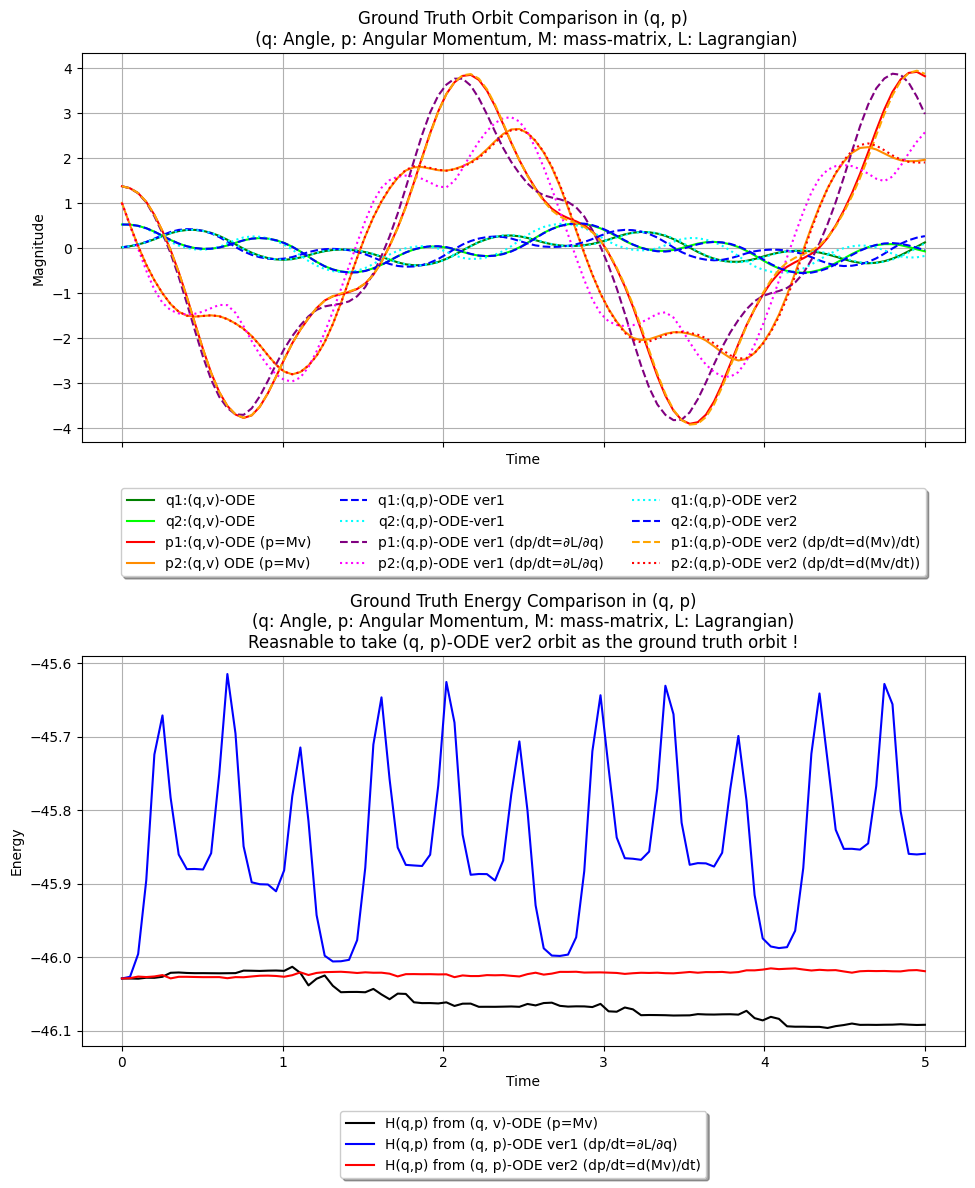

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Orbit comparison upon which ODE is adopted
ax1.set_title("Ground Truth Orbit Comparison in (q, p)\n (q: Angle, p: Angular Momentum, M: mass-matrix, L: Lagrangian)")
ax1.plot(tval_qp, true_x_qv2qp[:, 0], 'green', label='q1:(q,v)-ODE')
ax1.plot(tval_qp, true_x_qv2qp[:, 1], 'lime', label='q2:(q,v)-ODE')
ax1.plot(tval_qp, true_x_qv2qp[:, 2], 'red', label='p1:(q,v)-ODE (p=Mv)') 
ax1.plot(tval_qp, true_x_qv2qp[:, 3], 'darkorange', label='p2:(q,v) ODE (p=Mv)')
ax1.plot(tval_qp, true_x_qp_ver1[:, 0], 'blue', label='q1:(q,p)-ODE ver1', linestyle='--')
ax1.plot(tval_qp, true_x_qp_ver1[:, 1], 'cyan', label='q2:(q,p)-ODE-ver1', linestyle=':')
ax1.plot(tval_qp, true_x_qp_ver1[:, 2], 'purple', label='p1:(q.p)-ODE ver1 (dp/dt=∂L/∂q)', linestyle='--')
ax1.plot(tval_qp, true_x_qp_ver1[:, 3], 'magenta', label='p2:(q,p)-ODE ver1 (dp/dt=∂L/∂q)', linestyle=':')
ax1.plot(tval_qp, true_x_qp_ver2[:, 0], 'cyan', label='q1:(q,p)-ODE ver2', linestyle=':')
ax1.plot(tval_qp, true_x_qp_ver2[:, 1], 'blue', label='q2:(q,p)-ODE ver2', linestyle='--')
ax1.plot(tval_qp, true_x_qp_ver2[:, 2], 'orange', label='p1:(q,p)-ODE ver2 (dp/dt=d(Mv)/dt)', linestyle='--')
ax1.plot(tval_qp, true_x_qp_ver2[:, 3], 'red', label='p2:(q,p)-ODE ver2 (dp/dt=d(Mv/dt))', linestyle=':')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')
ax1.grid(True)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fancybox=True, shadow=True)
def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

# Energy comparision upon which ODE is adopted
true_energy_true_x_qv2qp = hamiltonian_qp(true_x_qv2qp[:,0], true_x_qv2qp[:,1], true_x_qv2qp[:,2], true_x_qv2qp[:,3], m1, m2, l1, l2, g)
true_energy_true_x_qp_ver1 = hamiltonian_qp(true_x_qp_ver1[:,0], true_x_qp_ver1[:,1], true_x_qp_ver1[:,2], true_x_qp_ver1[:,3], m1, m2, l1, l2, g)
true_energy_true_x_qp_ver2 = hamiltonian_qp(true_x_qp_ver2[:,0], true_x_qp_ver2[:,1], true_x_qp_ver2[:,2], true_x_qp_ver2[:,3], m1, m2, l1, l2, g)


ax2.set_title("Ground Truth Energy Comparison in (q, p)\n"
              "(q: Angle, p: Angular Momentum, M: mass-matrix, L: Lagrangian)\n"
              "Reasnable to take (q, p)-ODE ver2 orbit as the ground truth orbit !")
ax2.plot(tval_qp,true_energy_true_x_qv2qp, label='H(q,p) from (q, v)-ODE (p=Mv)', color='k', ls='-')
ax2.plot(tval_qp,true_energy_true_x_qp_ver1, label='H(q,p) from (q, p)-ODE ver1 (dp/dt=∂L/∂q)', color='b', ls='-')
ax2.plot(tval_qp,true_energy_true_x_qp_ver2, label='H(q,p) from (q, p)-ODE ver2 (dp/dt=d(Mv)/dt)', color='r', ls='-')
ax2.legend()
ax2.grid(True)
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.grid(True)

ax2.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=1,
    #fontsize='medium',
    fancybox=True, 
    shadow=True
)

plt.subplots_adjust(hspace=0.3) 

plt.tight_layout()

save_plot("hnn_dp_qp_reasonble_ground_truth_orbit_by_danieljh")

plt.show()

We SHOULD take the ground truth orbit from (q, p)-ODE ver 2 using dp/dt=d(Mv)/dt !

In [ ]:
# For comparision of orbits and energies
true_x_qp = true_x_qp_ver2


HNN x0 (q, p): [0.01825532 0.52412613 1.37291386 1.00350838]


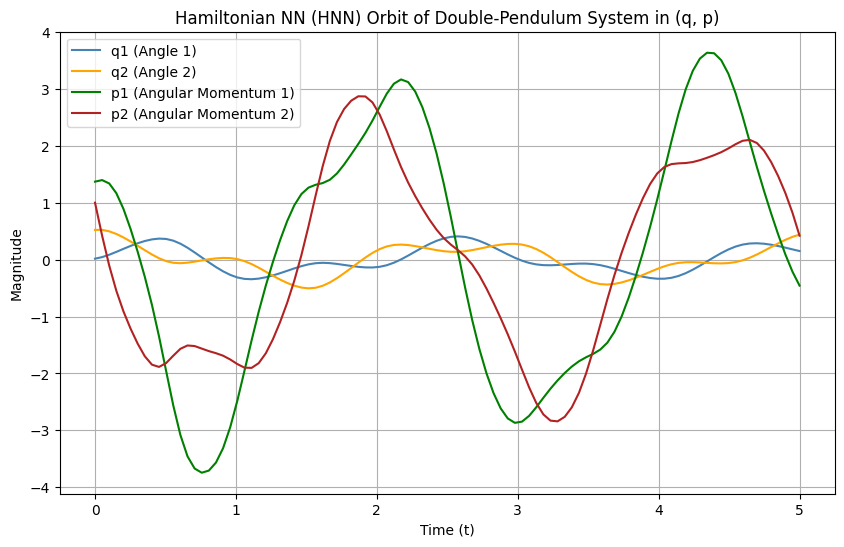

In [ ]:
# simulation
# parameters: same as the ground truth.
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1 + m2

# initial value conversion: (q1, q2, v1, v2) -> (q1, q2, p1, p2)
q1_0, q2_0, v1_0, v2_0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
p1_0, p2_0 = compute_momentum(q1_0, q2_0, v1_0, v2_0, m1, m2, l1, l2)
x0_qp = np.array([q1_0, q2_0, p1_0, p2_0])
print(f"HNN x0 (q, p): {x0_qp}")
trial = 9

mynet.load_state_dict(torch.load("./model/danieljh_hnn_dp_qp_sep_sc_2t_lr_{}".format(trial), map_location="cpu"))
mynet.eval()

import pandas as pd
A = pd.read_csv("./data/hnn_A_dp_qp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/hnn_B_dp_qp_sep_sc.csv", header=None, dtype=np.float32)

A = np.asmatrix(A)
B = np.asmatrix(B)
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()

def fvec_np(x,t):
    tx = torch.tensor(x, dtype=torch.float)
    x = torch.matmul(tx, torch.inverse(B))
    output = mynet.grad(x).squeeze(0)
    output = torch.matmul(A, output)
    output = output.squeeze(0)    
    return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0_qp,t_eval)

hnn_x_qp = res.copy()

plt.figure(figsize=(10, 6))
plt.plot(t_eval,res[:,0], 'steelblue', label='q1 (Angle 1)')
plt.plot(t_eval,res[:,1], 'orange', label='q2 (Angle 2)')
plt.plot(t_eval,res[:,2], 'g', label='p1 (Angular Momentum 1)')
plt.plot(t_eval,res[:,3], 'firebrick', label='p2 (Angular Momentum 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('Hamiltonian NN (HNN) Orbit of Double-Pendulum System in (q, p)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

hnn_energy_hnn_x_qp = net_energy(hnn_x_qp, t_eval).reshape((M))
hnn_energy_true_x_qp = net_energy(true_x_qp, t_eval).reshape((M))
true_energy_true_x_qp = true_energy_true_x_qp_ver2
true_energy_hnn_x_qp = hamiltonian_qp(hnn_x_qp[:,0], hnn_x_qp[:,1], hnn_x_qp[:,2], hnn_x_qp[:,3],
                                      m1, m2, l1, l2, g)


In [ ]:
def plot_qp_space_results(true_x_qp, hnn_x_qp, t_eval, 
                          Htrue_true_x_qp, Htrue_hnn_x_qp, 
                          Hmodel_true_x_qp, Hmodel_hnn_x_qp):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_x_qp[:, 0], 'steelblue', label='q1')
    axes[0, 0].plot(t_eval, true_x_qp[:, 1], 'g', label='q2')
    axes[0, 0].plot(t_eval, true_x_qp[:, 2], 'orange', label='p1')
    axes[0, 0].plot(t_eval, true_x_qp[:, 3], 'firebrick', label='p2')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylim([-4.25,4.25])
    axes[0, 0].set_title("Ground Truth Orbit in (q, p)\n"
                         "(q: Angle, p: Angular Momentum)")
    axes[0, 0].legend(loc='lower right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, hnn_x_qp[:, 0], 'steelblue', label='q1')
    axes[0, 1].plot(t_eval, hnn_x_qp[:, 1], 'g', label='q2')
    axes[0, 1].plot(t_eval, hnn_x_qp[:, 2], 'orange', label='p1')
    axes[0, 1].plot(t_eval, hnn_x_qp[:, 3], 'firebrick', label='p2')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylim([-4.25,4.25])
    axes[0, 1].set_title("Hamiltonian NN (HNN) Orbit in (q, p)\n"
                         "(q: Angle, p: Angular Momentum)")
    axes[0, 1].legend(loc='lower right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x_qp, 'k-', label='H_true(True_x_qp)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_hnn_x_qp, 'r--', label='H_true(HNN_x_qp)', linewidth=2)
    axes[1, 0].set_title("True Hamiltonian in (q, p)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('True Energy in (q, p)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    # --- Bottom Right Plot (1, 1): Learned Hamiltonian Perspective ---
    axes[1, 1].plot(t_eval, Hmodel_true_x_qp, 'k-', label='H_hnn_qp (True_x_qp)', linewidth=2)
    axes[1, 1].plot(t_eval, Hmodel_hnn_x_qp, 'r:', label='H_hnn_qp (HNN_x_qp)', linewidth=2)
    axes[1, 1].set_title("Hamiltonian Learned by Hamiltonian NN (HNN) in (q, p)", pad=tpad)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('HNN Energy in (q, p)')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(True)

    plt.tight_layout()

    save_plot("hnn_dp_qp_eval_figure_1_qp_space_by_danieljh")
 
    plt.show()


Graph saved at: ./eval_figures_per_model/hnn_dp_qp_eval_figure_1_qp_space_by_danieljh


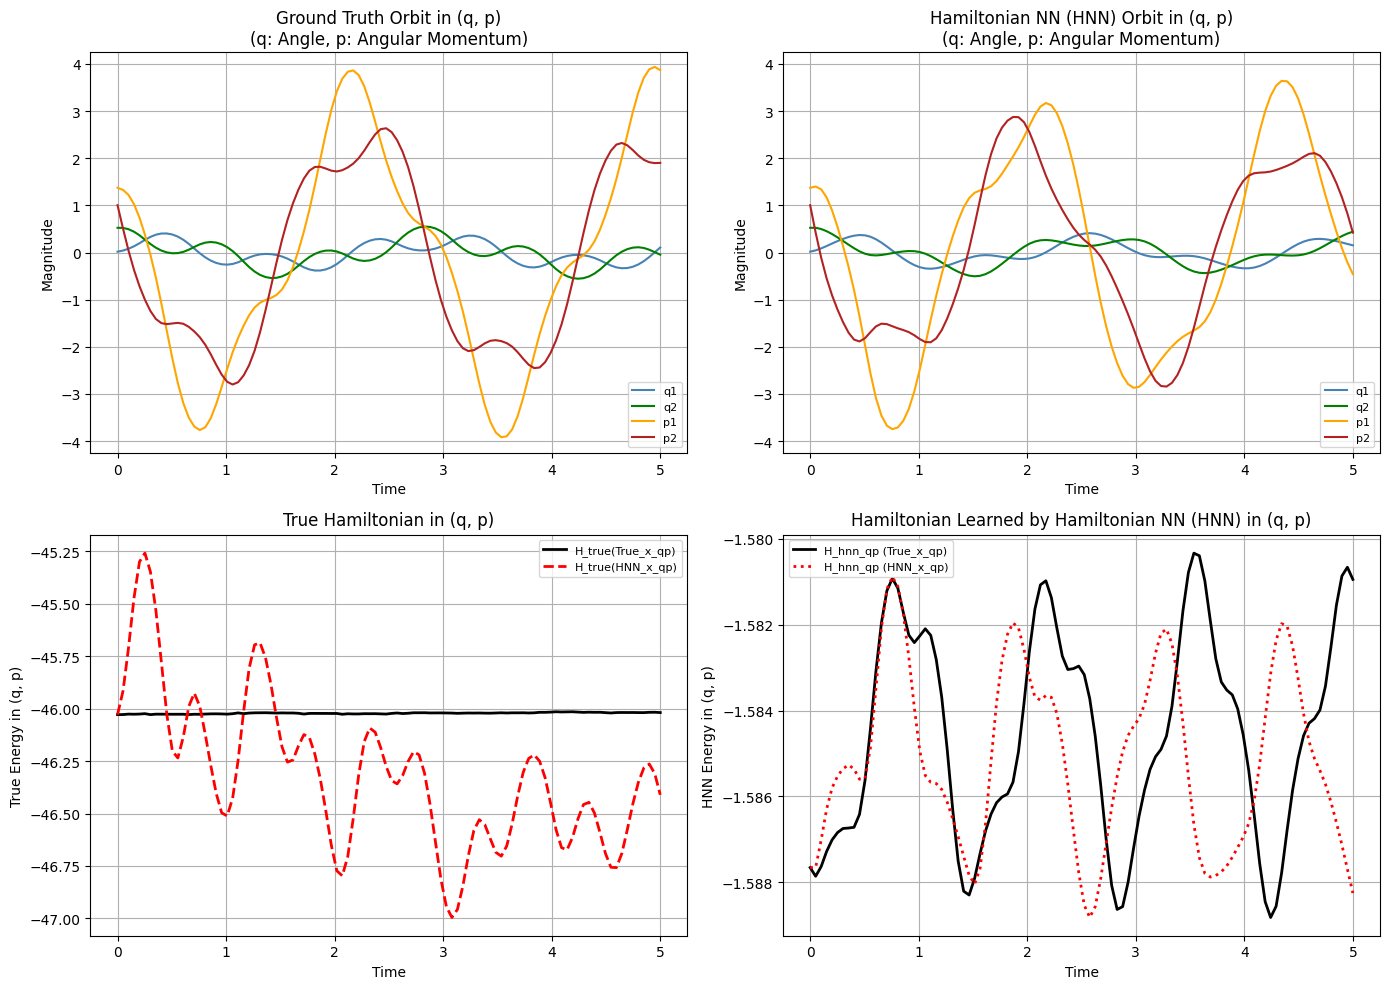

In [15]:
plot_qp_space_results(true_x_qp, hnn_x_qp, t_eval, 
                      true_energy_true_x_qp, true_energy_hnn_x_qp, 
                      hnn_energy_true_x_qp, hnn_energy_hnn_x_qp)

In [ ]:
def inv_mass_matrix_scalar(q1, q2, m1, m2, l1, l2):
    """
    Computes M_inv, the inverse matrix of M, the double-pendulum mass matrix.
    """
    cos12 = np.cos(q1 - q2)
    
    # M matrix elements
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2
    
    # Determinant
    detM = M11 * M22 - M12**2

    # Inverse matrix elements
    InvM11 = M22 / detM
    InvM12 = -M12 / detM
    InvM22 = M11 / detM

    # Initialize M_q
    if np.ndim(q1) > 0:
        # q1: array --> (..., 2, 2)
        M_inv = np.zeros(q1.shape + (2, 2))
    
    # Arrange values in (100, 2, 2) shape by broadcasting
    M_inv[..., 0, 0] = InvM11
    M_inv[..., 0, 1] = InvM12
    M_inv[..., 1, 0] = InvM12
    M_inv[..., 1, 1] = InvM22

    return M_inv

def convert_qp_to_qv(q1, q2, p1, p2, m1, m2, l1, l2):
    """
    Converts (q, p) orbit to (q, v) orbit.
    """
    # 1. Mass-matrix M(q): (M, 2, 2)
    M_q = mass_matrix(q1, q2, m1, m2, l1, l2)

    # 2. Momentum vector p_vec: (M, 2)
    p_vec = np.vstack([p1, p2]).T

    # 3. Computes inv(M): (M, 2, 2)
    inv_M = inv_mass_matrix_scalar(q1, q2, m1, m2, l1, l2)

    # 4. Velocity vector v_vec: v = inv(M) @ p -> (M, 2)
    v_vec = np.einsum('Nij, Nj->Ni', inv_M, p_vec)

    # 5. v1, v2
    v1 = v_vec[:, 0]
    v2 = v_vec[:, 1]

    return q1, q2, v1, v2

qt1, q2t, vt1, vt2 = convert_qp_to_qv(hnn_x_qp[:,0], hnn_x_qp[:,1], hnn_x_qp[:,2], hnn_x_qp[:,3], m1, m2, l1, l2)
hnn_x_qv = np.vstack([qt1, q2t, vt1, vt2]).T  # (M, 4) [q1, q2, v1, v2]

In [ ]:
def hamiltonian_qv(state):
    """
    Based on the given state vector (q1, q2, v1, v2), 
    computes the total energy (Hamiltonian) of the double-pendulum system.

    Here:
    q1 = theta1 (Angle 1)
    q2 = theta2 (Angle 2)
    v1 = omega1 (Angular Velocity 1)
    v2 = omega2 (Angular Velocity 2)
    """
    theta1 = state[:,0]
    theta2 = state[:,1]
    omega1 = state[:,2]
    omega2 = state[:,3]
    
    # --- Kinetic Energy ---   
    T1 = 0.5 * m1 * (l1 * omega1)**2
    T2 = 0.5 * m2 * (
        (l1 * omega1)**2 + 
        (l2 * omega2)**2 + 
        2 * l1 * l2 * omega1 * omega2 * np.cos(theta1 - theta2)
    )
    kinetic_energy = T1 + T2
    
    # --- Potential Energy ---   
    V1 = -m1 * g * l1 * np.cos(theta1)
    V2 = -m2 * g * (1 * np.cos(theta1) + l2 * np.cos(theta2))
    potential_energy = V1 + V2

    return (kinetic_energy + potential_energy)

Htrue_true_x_qv = hamiltonian_qv(true_x_qv)
Htrue_hnn_x_qv = hamiltonian_qv(hnn_x_qv)

print('Htrue_true_x_qv shape:', Htrue_true_x_qv.shape)
print('Htrue_hnn_x_qv shape:', Htrue_hnn_x_qv.shape)


Htrue_true_x_qv shape: (100,)
Htrue_hnn_x_qv shape: (100,)


In [ ]:
def plot_qv_space_results(true_x_qv, hnn_x_qv, t_eval, Htrue_true_x_qv, Htrue_hnn_x_qv):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_x_qv[:, 0], 'steelblue', label='q1')
    axes[0, 0].plot(t_eval, true_x_qv[:, 1], 'g', label='q2')
    axes[0, 0].plot(t_eval, true_x_qv[:, 2], 'orange', label='p1')
    axes[0, 0].plot(t_eval, true_x_qv[:, 3], 'firebrick', label='p2')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylim([-3,3])
    axes[0, 0].set_title("Ground Truth Orbit in (q, v)\n"
                         "(q: Angle, v: Angular Velocity)")
    axes[0, 0].legend(loc='lower right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, hnn_x_qv[:, 0], 'steelblue', label='q1')
    axes[0, 1].plot(t_eval, hnn_x_qv[:, 1], 'g', label='q2')
    axes[0, 1].plot(t_eval, hnn_x_qv[:, 2], 'orange', label='p1')
    axes[0, 1].plot(t_eval, hnn_x_qv[:, 3], 'firebrick', label='p2')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylim([-3,3])
    axes[0, 1].set_title("Hamiltonian NN (HNN) Orbit in (q, v): v = M$^{-1}$ p\n"
                         "(q: Angle, v: Angular Velocity, M: mass-matrix, p: Angular Momentum)")
    axes[0, 1].legend(loc='lower right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x_qv, 'k-', label='H_true(True_x_qv)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_hnn_x_qv, 'b--', label='H_true(HNN_x_qv)', linewidth=2)
    axes[1, 0].set_title("True Hamiltonian in (q, v)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('True Energy in (q, v)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    plt.tight_layout()

    save_plot("hnn_dp_qp_eval_figure_2_qv_space_by_danieljh")
 
    plt.show()

Graph saved at: ./eval_figures_per_model/hnn_dp_qp_eval_figure_2_qv_space_by_danieljh


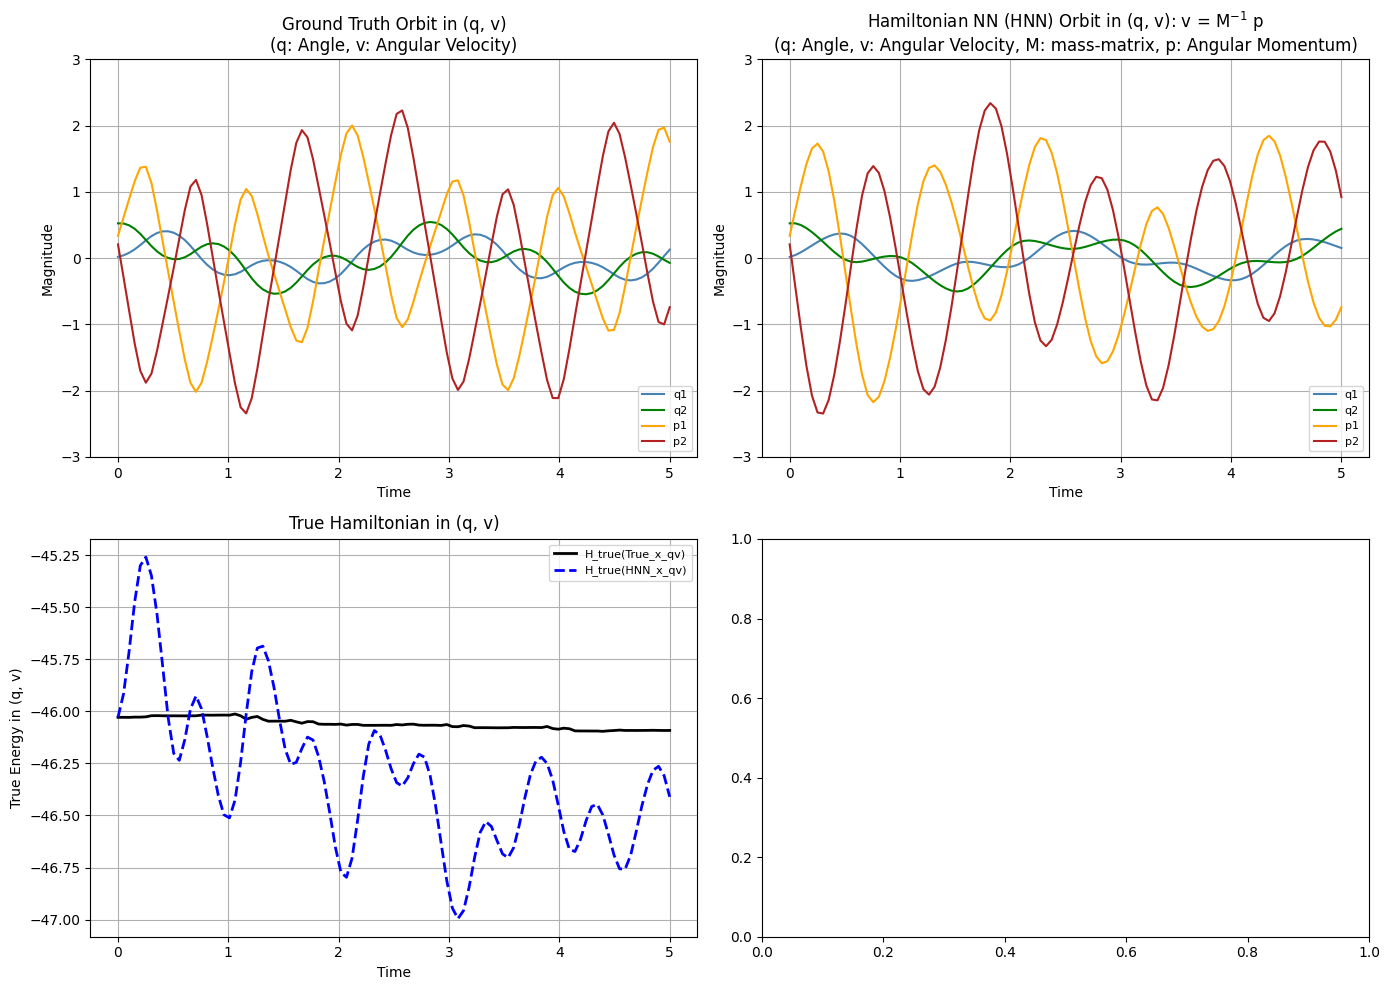

In [19]:
plot_qv_space_results(true_x_qv, hnn_x_qv, t_eval, Htrue_true_x_qv, Htrue_hnn_x_qv)

In [ ]:
''' In order to compare performances across models, exports orbit, etc. to file '''
def save_data(data, model="TRUE_dp", item='orbit', t_end=tend, dir = './comparison'): 
    # model = "TRUE", "HNN" "LNN", "SYM", "SKEW", "NODE"
    file_path = dir + f'/{model}_{item}_tend_{t_end}.npy'
    np.save(file_path, data)

    print(f"Data have successfully saved to {file_path}.")

In [ ]:
save_data(true_x_qp, model="TRUE_dp_qp", item="orbit")
save_data(true_x_qv, model="TRUE_dp_qv", item="orbit")
save_data(hnn_x_qp, model="HNN_dp_qp", item="orbit")
save_data(hnn_x_qv, model="HNN_dp_qv", item="orbit")
save_data(true_energy_true_x_qp, model="HNN_dp_qp", item="Htrue_true_x_qp")
save_data(true_energy_hnn_x_qp, model="HNN_dp_qp", item='Htrue_hnn_x_qp')
save_data(hnn_energy_true_x_qp, model="HNN_dp_qp", item='Hmodel_true_x_qp')
save_data(hnn_energy_true_x_qp, model="HNN_dp_qp", item='Hmodel_hnn_x_qp')

데이터가 ./comparison/TRUE_dp_qp_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/TRUE_dp_qv_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_qp_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_qv_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_qp_Htrue_true_x_qp_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_qp_Htrue_hnn_x_qp_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_qp_Hmodel_true_x_qp_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_qp_Hmodel_hnn_x_qp_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
